In [1]:
import pandas as pd
import vertica_python
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os
import scipy
from scipy.interpolate import UnivariateSpline
from scipy.stats import ttest_ind

In [2]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

# Queries
* * *
### Mapping users and courses to outcomes

In [3]:
#
#DROP TABLE IF EXISTS ahemphill.self_paced_vs_instructor_led_master;
#CREATE TABLE ahemphill.self_paced_vs_instructor_led_master AS
#SELECT 
#	e.user_id,
#	e.course_id,
#	e.user_current_enrollment_mode,
#	e.user_first_enrollment_time,
#	e.user_last_unenrollment_time,
#	e.user_first_verified_enrollment_time,
#	e.course_subject,
#	e.course_announcedate,
#	e.course_start_date,
#	e.course_end_date,
#	e.course_self_paced,
#       REGEXP_SUBSTR(e.course_id, '[1-4]T201[5-6]') AS course_term,
#	e.user_enroll_from_course_start_days,
#	e.user_enroll_from_course_start_days_min_zero,
#	e.user_verify_from_course_start_days,
#	e.user_verify_from_course_start_days_min_zero,
#	e.user_final_grade,
#	e.user_has_passed,
#	e.user_certificate_mode
#FROM
#(
#SELECT
#	a.user_id,
#	a.course_id,
#	a.current_enrollment_mode AS user_current_enrollment_mode,
#	a.first_enrollment_time AS user_first_enrollment_time,
#	a.last_unenrollment_time AS user_last_unenrollment_time,
#	a.first_verified_enrollment_time AS user_first_verified_enrollment_time,
#	b.subject AS course_subject,
#	c.announcedate AS course_announcedate,
#	c.startdate AS course_start_date,
#	c.enddate AS course_end_date,
#	c.SelfPaced AS course_self_paced,
#	DATEDIFF('day', c.startdate, a.first_enrollment_time) AS user_enroll_from_course_start_days,
#	CASE
#		WHEN
#			DATEDIFF('day', c.startdate, a.first_enrollment_time) < 0
#	THEN 
#		0
#	ELSE 
#		DATEDIFF('day', c.startdate, a.first_enrollment_time)
#	END AS user_enroll_from_course_start_days_min_zero,
#	DATEDIFF('day', c.startdate, a.first_verified_enrollment_time) AS user_verify_from_course_start_days,
#	CASE
#		WHEN
#			DATEDIFF('day', c.startdate, a.first_verified_enrollment_time) < 0
#	THEN 
#		0
#	ELSE 
#		DATEDIFF('day', c.startdate, a.first_verified_enrollment_time)
#	END AS user_verify_from_course_start_days_min_zero,
#	d.final_grade AS user_final_grade,
#	d.has_passed AS user_has_passed,
#	d.certificate_mode AS user_certificate_mode,
#	row_number() OVER (PARTITION BY a.user_id, a.course_id ORDER BY a.course_id ASC) AS rank
#FROM
#	production.d_user_course a
#LEFT JOIN
#	ahemphill.course_subjects_master b
#ON
#	a.course_id = b.course_id
#LEFT JOIN
#	ed_services.CourseCatalog_20161017 c
#ON
#	a.course_id = c.CourseID
#LEFT JOIN
#	production.d_user_course_certificate d
#ON
#	a.course_id = d.course_id
#	AND a.user_id = d.user_id
#) e
#WHERE 
#	e.rank = 1;


## Calculating percent of certificates granted per course

In [4]:
#DROP TABLE IF EXISTS ahemphill.course_pct_certifications_issued;
#CREATE TABLE ahemphill.course_pct_certifications_issued AS
#SELECT 
#	course_id, 
#	course_self_paced, 
#	COUNT(1) AS cnt_eligible_users, 
#	SUM(CASE WHEN user_has_passed IS NULL THEN 1 ELSE 0 END) AS cnt_no_certificates, 
#	SUM(CASE WHEN user_has_passed IS NULL THEN 1 ELSE 0 END)*100.0/COUNT(1) AS pct_no_certificates
#FROM
#	ahemphill.self_paced_vs_instructor_led_master
#WHERE
#	course_end_date BETWEEN '2015-07-01' AND '2016-07-01'
#	AND user_first_enrollment_time < course_end_date
#	AND user_last_unenrollment_time IS NULL
#GROUP BY 
#	course_id,
#	course_self_paced

### Join the two

In [5]:
course_enrollments_and_verifs = """

DROP TABLE IF EXISTS ahemphill.course_enrollments_and_verifs;
CREATE TABLE ahemphill.course_enrollments_and_verifs AS 
SELECT
	a.*,
    b.pct_no_certificates
FROM
    ahemphill.self_paced_vs_instructor_led_master a
JOIN
    ahemphill.course_pct_certifications_issued b
ON
    a.course_id = b.course_id;
"""

In [6]:
enrollments_and_completions_query = """

SELECT
    course_id,
    user_enroll_from_course_start_days_min_zero,
    user_enroll_from_course_start_days,
    pct_no_certificates,
    course_self_paced,
    course_subject,
    course_term,
    user_verify_from_course_start_days,
    user_verify_from_course_start_days_min_zero,
    COUNT(1) AS cnt_enrolls,
    SUM(CASE WHEN user_verify_from_course_start_days_min_zero IS NOT NULL THEN 1 ELSE 0 END) AS cnt_verifs
FROM
    ahemphill.course_enrollments_and_verifs
GROUP BY 
    1,2,3,4,5,6,7,8,9
"""

In [7]:
seasonality_normalization_query = """

SELECT  
	REGEXP_SUBSTR(course_id, '[1-4]T201[5-6]') AS term,
	COUNT(1) AS enrollments,
	COUNT(distinct course_id) AS courses_offered,
	COUNT(1)/COUNT(distinct course_id) AS enrollment_per_course,
	SUM(CASE WHEN user_first_verified_enrollment_time IS NOT NULL THEN 1 else 0 end) AS verifications
FROM
	ahemphill.self_paced_vs_instructor_led_master
WHERE 
	REGEXP_SUBSTR(course_id, '[1-3]T201[5-6]') IS NOT NULL
GROUP BY 
	1

"""

In [8]:
term_prioritization_dict = {
    
    '1T2015': [1],
    '2T2015': [2],
    '3T2015': [3],
    '4T2015': [4],
    '1T2016': [5],
    '2T2016': [6],
    '3T2016': [7],   
    '4T2016': [8], 
}

course_run_prio_df = pd.DataFrame.from_dict(term_prioritization_dict).T
course_run_prio_df.columns = ['priority']

In [9]:
plot_order = [
    '1T2015',
    '2T2015',
    '3T2015',
    '4T2015',
    '1T2016',
    '2T2016',
    '3T2016'
]

big3_subjects = [
'Computer Science',
'Data Analysis & Statistics',
'Business & Management'
]

df_col_names = [
'course_subject',
'course_self_paced',
'course_id',
u'cnt_enrolls',
u'cnt_verifs',
u'user_enroll_from_course_start_days',
u'user_enroll_from_course_start_days_min_zero',
u'user_verify_from_course_start_days_min_zero'   
]

In [15]:
connection = vertica_python.connect(**conn_info)

#cur = connection.cursor('dict')
#cur.execute(course_enrollments_and_verifs)

cur = connection.cursor('dict')
cur.execute(enrollments_and_completions_query)
extract = cur.fetchall()
enrollments_and_completions_df = pd.DataFrame(extract)

cur = connection.cursor('dict')
cur.execute(seasonality_normalization_query)
extract = cur.fetchall()
seasonality_normalization = pd.DataFrame(extract)

connection.close()

ConnectionError: [Errno 60] Operation timed out

In [724]:
master_df = enrollments_and_completions_df

In [725]:
len(master_df)

305795

In [726]:
#Pull aggregate user activity stats for courses per date

### Filter all courses w/less than 1000 enrollments

In [727]:
filter_low_enrollment_count_df = enrollments_and_completions_df.groupby('course_id').sum().reset_index()
filter_low_enrollment_count_df = filter_low_enrollment_count_df[filter_low_enrollment_count_df.cnt_enrolls 
                                                                >= 1000]
filtered_course_list = filter_low_enrollment_count_df.course_id.unique()
enrollments_and_completions_df = pd.merge(enrollments_and_completions_df, 
                                          filter_low_enrollment_count_df['course_id'].reset_index(), 
                                          how='inner', on='course_id')

In [728]:
len(enrollments_and_completions_df)

302992

In [729]:
announce_date_df = enrollments_and_completions_df.groupby('course_id').quantile(0.05).reset_index()
announce_date_df = announce_date_df.set_index('course_id').user_enroll_from_course_start_days.reset_index()

In [730]:
announce_date_df.head()

,course_id,user_enroll_from_course_start_days
0,ANUx/ANU-ASTRO2x/2T2014,-156.30
1,ANUx/ANU-ASTRO4x/1T2015,-51.00
2,BerkeleyX/BFV101x/T12015,-271.70
3,BerkeleyX/BJC.1x/3T2015,-328.95
4,BerkeleyX/BJC.2x/3T2015,-378.10


In [731]:
enrollments_and_completions_df = pd.merge(enrollments_and_completions_df,announce_date_df,how='inner', on='course_id')


In [742]:
enrollments_and_completions_df = enrollments_and_completions_df.rename(columns={
        "user_enroll_from_course_start_days_x": "user_enroll_from_course_start_days",
        "user_enroll_from_course_start_days_y": "announce_date"})

In [743]:
enrollments_aggregate = enrollments_and_completions_df.groupby(
    ['course_subject','course_self_paced', 'course_id']).sum().reset_index()
#enrollments_aggregate_30d = enrollments_and_completions_df_30d_filtered.groupby(['course_subject','course_self_paced', 'course_id']).sum().reset_index()

In [744]:
len(enrollments_and_completions_df)

302992

In [745]:
enrollments_and_completions_df.head()

,cnt_enrolls,cnt_verifs,course_id,course_self_paced,course_subject,course_term,pct_no_certificates,user_enroll_from_course_start_days,user_enroll_from_course_start_days_min_zero,user_verify_from_course_start_days,user_verify_from_course_start_days_min_zero,index,announce_date
0,1,1,IITBombayX/ME209.1x/2T2015,Yes,Engineering,2T2015,0E-19,43,43,87.0,87.0,34,9.0
1,44,0,IITBombayX/ME209.1x/2T2015,Yes,Engineering,2T2015,0E-19,122,122,NaN,NaN,34,9.0
2,1,1,IITBombayX/ME209.1x/2T2015,Yes,Engineering,2T2015,0E-19,13,13,32.0,32.0,34,9.0
3,44,0,IITBombayX/ME209.1x/2T2015,Yes,Engineering,2T2015,0E-19,85,85,NaN,NaN,34,9.0
4,51,0,IITBombayX/ME209.1x/2T2015,Yes,Engineering,2T2015,0E-19,196,196,NaN,NaN,34,9.0


In [790]:
course_perf_announce_date = enrollments_and_completions_df[
    (enrollments_and_completions_df.user_enroll_from_course_start_days >= -60) 
    & (enrollments_and_completions_df.user_enroll_from_course_start_days < -30)].groupby(
    ['course_id','course_self_paced','course_term']).sum()
course_perf_announce_date['range'] = '60d_to_30d'

In [806]:
course_perf_announce_date = pd.DataFrame()

In [808]:
for i in np.arange(-30,30):
    
    course_perf_announce_date_temp = enrollments_and_completions_df[
        enrollments_and_completions_df.user_enroll_from_course_start_days == i].groupby(
        ['course_id','course_self_paced','course_term']).sum()
    course_perf_announce_date_temp['range'] = i
    course_perf_announce_date = course_perf_announce_date.append(course_perf_announce_date_temp)

In [791]:
course_perf_announce_date_temp = enrollments_and_completions_df[
    (enrollments_and_completions_df.user_enroll_from_course_start_days >= -30) 
    & (enrollments_and_completions_df.user_enroll_from_course_start_days < -14)].groupby(
    ['course_id','course_self_paced','course_term']).sum()
course_perf_announce_date_temp['range'] = '30d_to_14d'
course_perf_announce_date = course_perf_announce_date.append(course_perf_announce_date_temp)

In [792]:
course_perf_announce_date_temp = enrollments_and_completions_df[
    (enrollments_and_completions_df.user_enroll_from_course_start_days >= -14) & 
    (enrollments_and_completions_df.user_enroll_from_course_start_days <= 0)].groupby(
    ['course_id','course_self_paced','course_term']).sum()
course_perf_announce_date_temp['range'] = '14d_to_0d'
course_perf_announce_date = course_perf_announce_date.append(course_perf_announce_date_temp)

In [793]:
course_perf_announce_date_temp = enrollments_and_completions_df[
    (enrollments_and_completions_df.announce_date >= 0) & 
    (enrollments_and_completions_df.announce_date < 14)].groupby(
    ['course_id','course_self_paced','course_term']).sum()
course_perf_announce_date_temp['range'] = '0d_to_14d'
course_perf_announce_date = course_perf_announce_date.append(course_perf_announce_date_temp)

In [794]:
course_perf_announce_date_temp = enrollments_and_completions_df[
    (enrollments_and_completions_df.announce_date >= 1) & 
    (enrollments_and_completions_df.announce_date < 14)].groupby(
    ['course_id','course_self_paced','course_term']).sum()
course_perf_announce_date_temp['range'] = '1d_to_14d'
course_perf_announce_date = course_perf_announce_date.append(course_perf_announce_date_temp)

In [795]:
course_perf_announce_date_temp = enrollments_and_completions_df[
    (enrollments_and_completions_df.announce_date >= 7) & 
    (enrollments_and_completions_df.announce_date < 14)].groupby(
    ['course_id','course_self_paced','course_term']).sum()
course_perf_announce_date_temp['range'] = '7d_to_14d'
course_perf_announce_date = course_perf_announce_date.append(course_perf_announce_date_temp)

In [796]:
course_perf_announce_date_temp = enrollments_and_completions_df[
    (enrollments_and_completions_df.announce_date >= 14) & 
    (enrollments_and_completions_df.announce_date < 28)].groupby(
    ['course_id','course_self_paced','course_term']).sum()
course_perf_announce_date_temp['range'] = '14d_to_28d'
course_perf_announce_date = course_perf_announce_date.append(course_perf_announce_date_temp)

In [810]:
course_perf_announce_date['vtr'] = course_perf_announce_date.cnt_verifs * 100.0/course_perf_announce_date.cnt_enrolls

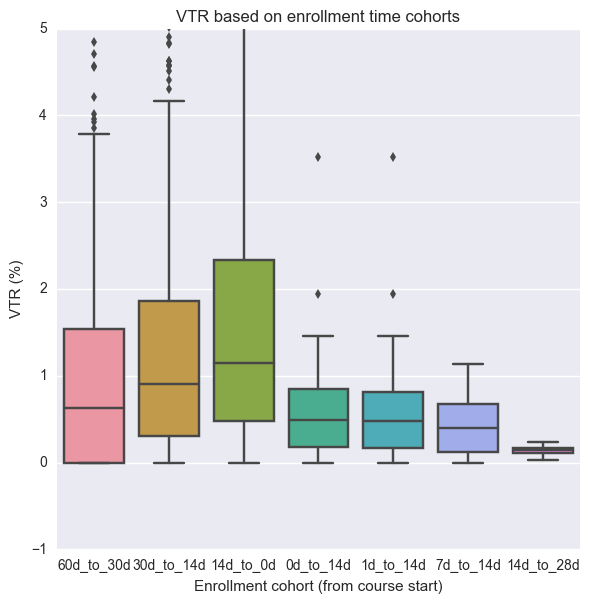

In [798]:
ax = sns.factorplot(data=course_perf_announce_date.reset_index(), x ='range', y='vtr', kind='box', size = 6)
ax.set(ylim=(-1,5),ylabel='VTR (%)',xlabel = 'Enrollment cohort (from course start)', title = 'VTR based on enrollment time cohorts')

In [14]:
course_perf_announce_date.head()

NameError: name 'course_perf_announce_date' is not defined

In [799]:
print 'Comparing VTR across 60d-30d and 30d-14d cohorts results in a p-value of %f' % ttest_ind(course_perf_announce_date[course_perf_announce_date.range=='60d_to_30d'].vtr,
          course_perf_announce_date[course_perf_announce_date.range=='30d_to_14d'].vtr)[1]

print 'Comparing VTR across 30d-14d and 14d-0d cohorts results in a p-value of %f' %  ttest_ind(course_perf_announce_date[course_perf_announce_date.range=='30d_to_14d'].vtr,
          course_perf_announce_date[course_perf_announce_date.range=='14d_to_0d'].vtr)[1]

Comparing VTR across 60d-30d and 30d-14d cohorts results in a p-value of 0.050942
Comparing VTR across 30d-14d and 14d-0d cohorts results in a p-value of 0.029644


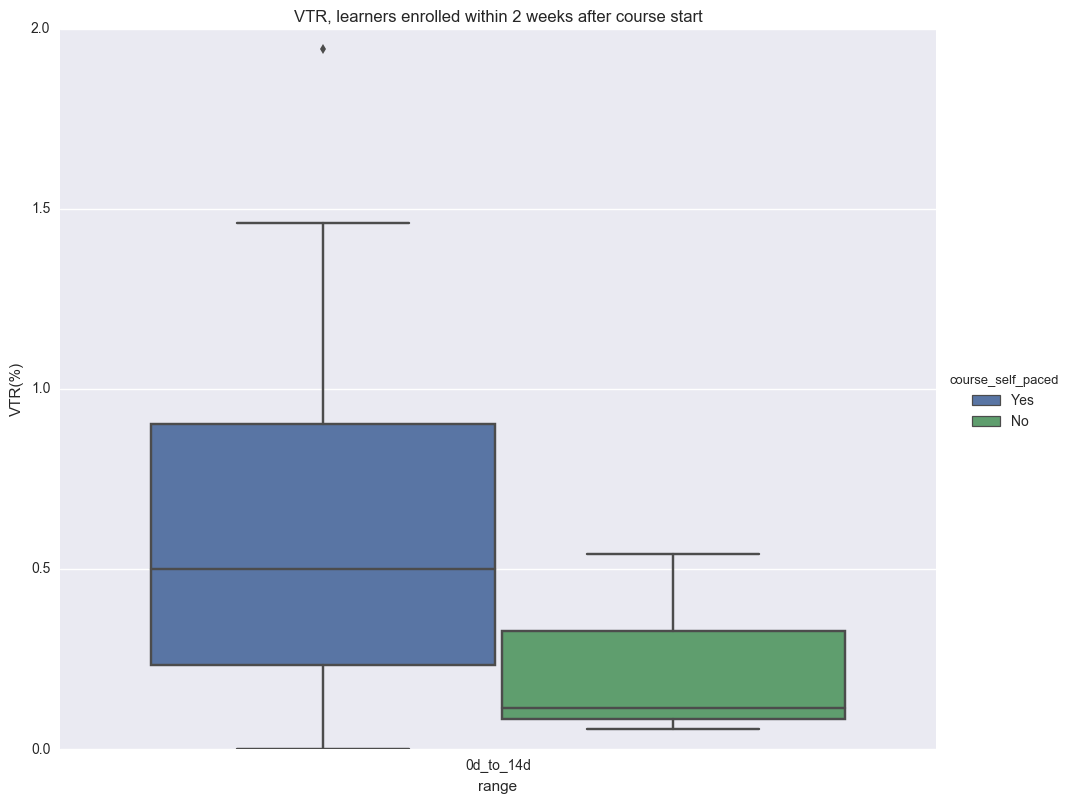

In [803]:
ax = sns.factorplot(data=course_perf_announce_date[course_perf_announce_date.range=='0d_to_14d']
                    .reset_index(), x ='range', y='vtr', kind='box', hue='course_self_paced', size =8, aspect =1.2)
ax.set(ylim=(0,2), title= 'VTR, learners enrolled within 2 weeks after course start', xlabel='range', ylabel='VTR(%)')

In [822]:
course_perf_announce_date['rolling']=pd.rolling_mean(course_perf_announce_date, 7).reset_index().vtr

/Users/adleyhemphill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=7,center=False).mean()
  if __name__ == '__main__':


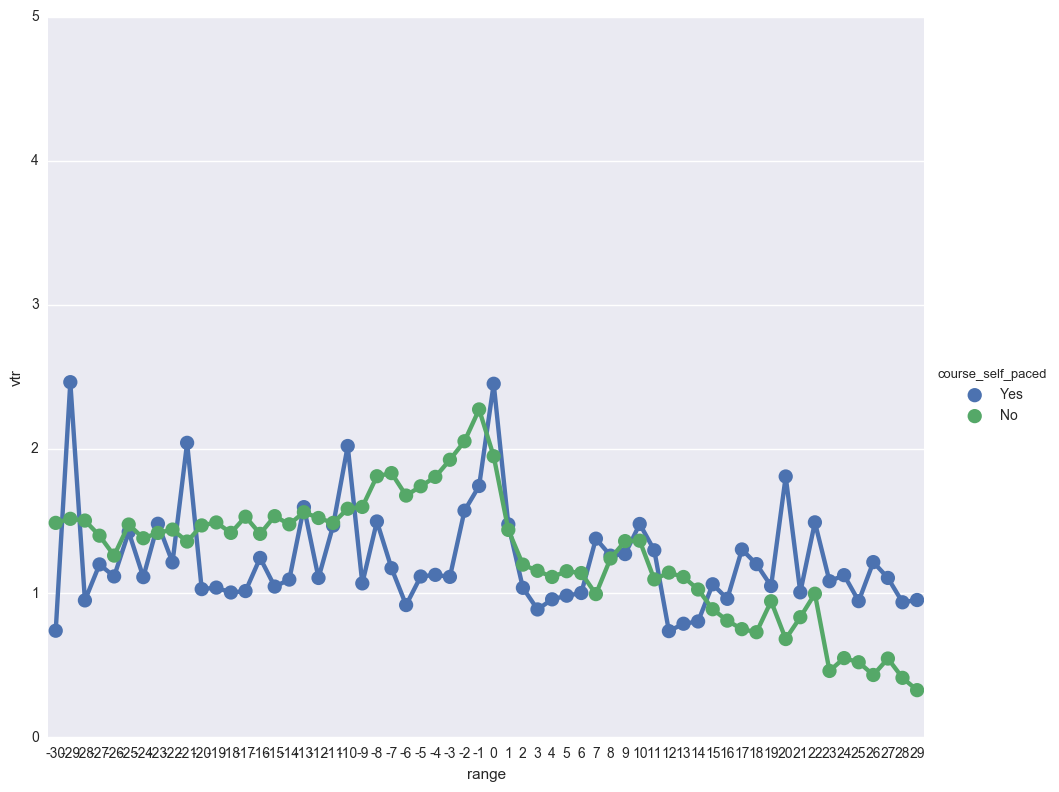

In [828]:
ax = sns.factorplot(data=course_perf_announce_date.reset_index(), 
                    x ='range', y='vtr', kind='point', hue='course_self_paced', size =8, aspect =1.2, ci = False)
ax.set(ylim=(0,5))

# Blah blah blah, controlled studies are really hard

In [757]:
ax = sns.factorplot(data=announce_date_df, x='course_term', y='user_enroll_from_course_start_days'
               , kind='box', hue='course_self_paced', size = 8, order=plot_order, aspect=1.2)
ax.set(title = 'Course First Enrollment Date Relative to Course Start Date'
       ,ylabel='Days from first enrollment to course start',xlabel='term')

ValueError: Could not interpret input 'course_term'

* * *
# Comparing Distributions of Enrollments
### Across a few different facets
* * *

# Placeholder to show how instructor led courses have quicker ramp

# In aggregate, no difference in key statistics when splitting by pacing type

In [829]:
enrollments_aggregate['vtr'] = enrollments_aggregate.cnt_verifs*100.0/enrollments_aggregate.cnt_enrolls

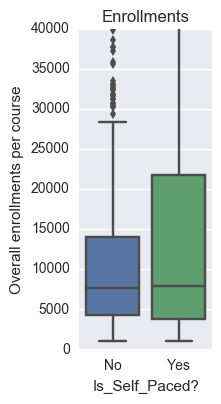

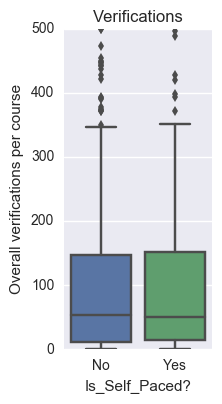

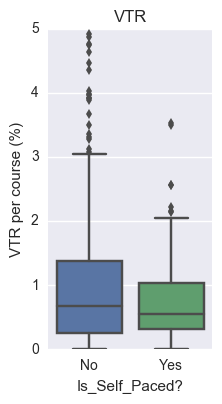

In [830]:
ax = sns.factorplot(data = enrollments_aggregate, x = 'course_self_paced', 
                    y = 'cnt_enrolls', kind = 'box', size = 4, aspect = 0.6)
ax.set(ylim=(0,40000), xlabel='Is_Self_Paced?', ylabel='Overall enrollments per course',
       title = 'Enrollments')

ax = sns.factorplot(data = enrollments_aggregate, x = 'course_self_paced', 
                    y = 'cnt_verifs', kind = 'box', size = 4, aspect = 0.6)
ax.set(ylim=(0,500), xlabel='Is_Self_Paced?', ylabel='Overall verifications per course',
       title = 'Verifications')
ax = sns.factorplot(data = enrollments_aggregate, x = 'course_self_paced', 
                    y = 'vtr', kind = 'box', size = 4, aspect = 0.6)
ax.set(ylim=(0,5), xlabel='Is_Self_Paced?', ylabel='VTR per course (%)',
       title = 'VTR')

In [760]:
print ttest_ind(enrollments_aggregate[enrollments_aggregate.course_self_paced=='Yes'].cnt_enrolls,
          enrollments_aggregate[enrollments_aggregate.course_self_paced=='No'].cnt_enrolls)[1]

print ttest_ind(enrollments_aggregate[enrollments_aggregate.course_self_paced=='Yes'].cnt_verifs,
          enrollments_aggregate[enrollments_aggregate.course_self_paced=='No'].cnt_verifs)[1]

print ttest_ind(enrollments_aggregate[enrollments_aggregate.course_self_paced=='Yes'].vtr,
          enrollments_aggregate[enrollments_aggregate.course_self_paced=='No'].vtr)[1]

0.00119507612954
0.27406893998
0.260249921589


### Filter to just CS, Business, and Data

In [831]:
enrollments_aggregate_big3 = enrollments_aggregate[(enrollments_aggregate['course_subject']=='Computer Science') | 
                     (enrollments_aggregate['course_subject']=='Business & Management') |
                     (enrollments_aggregate['course_subject']=='Data Analysis and Statistics') ]

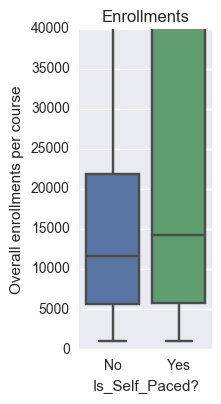

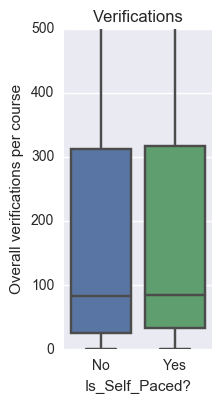

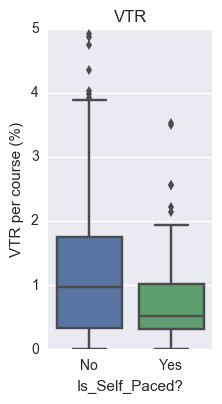

In [832]:
ax = sns.factorplot(data = enrollments_aggregate_big3, x = 'course_self_paced', 
                    y = 'cnt_enrolls', kind = 'box', size = 4, aspect = 0.6)
ax.set(ylim=(0,40000), xlabel='Is_Self_Paced?', ylabel='Overall enrollments per course',
       title = 'Enrollments')

ax = sns.factorplot(data = enrollments_aggregate_big3, x = 'course_self_paced', 
                    y = 'cnt_verifs', kind = 'box', size = 4, aspect = 0.6)
ax.set(ylim=(0,500), xlabel='Is_Self_Paced?', ylabel='Overall verifications per course',
       title = 'Verifications')

ax = sns.factorplot(data = enrollments_aggregate_big3, x = 'course_self_paced', 
                    y = 'vtr', kind = 'box', size = 4, aspect = 0.6)
ax.set(ylim=(0,5), xlabel='Is_Self_Paced?', ylabel='VTR per course (%)',
       title = 'VTR')

In [764]:
print ttest_ind(enrollments_aggregate_big3[enrollments_aggregate_big3.course_self_paced=='Yes'].cnt_enrolls,
          enrollments_aggregate_big3[enrollments_aggregate_big3.course_self_paced=='No'].cnt_enrolls)[1]

print ttest_ind(enrollments_aggregate_big3[enrollments_aggregate_big3.course_self_paced=='Yes'].cnt_verifs,
          enrollments_aggregate_big3[enrollments_aggregate_big3.course_self_paced=='No'].cnt_verifs)[1]

print ttest_ind(enrollments_aggregate_big3[enrollments_aggregate_big3.course_self_paced=='Yes'].vtr,
          enrollments_aggregate_big3[enrollments_aggregate_big3.course_self_paced=='No'].vtr)[1]

0.0140800910507
0.115754742443
0.444855915707


# Filter to only include courses where course announcement happened 30d or later to the course start 

In [833]:
enrollments_and_completions_df_30d_filtered = pd.merge(enrollments_and_completions_df, 
                                                       announce_date_filter_df, how='inner', on='course_id')
enrollments_and_completions_df_30d_filtered = enrollments_and_completions_df_30d_filtered[
    enrollments_and_completions_df_30d_filtered['user_enroll_from_course_start_days_y']>= -30]

In [834]:
enrollments_aggregate_30d['vtr'] = enrollments_aggregate_30d.cnt_verifs*100.0/enrollments_aggregate_30d.cnt_enrolls
enrollments_aggregate_30d = enrollments_aggregate_30d[enrollments_aggregate_30d.cnt_enrolls > 1000]

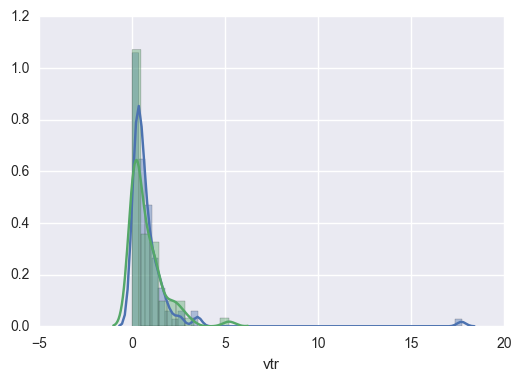

In [835]:
sns.distplot(enrollments_aggregate_30d[enrollments_aggregate_30d.course_self_paced == 'Yes'].vtr, label='Self Paced')
sns.distplot(enrollments_aggregate_30d[enrollments_aggregate_30d.course_self_paced == 'No'].vtr, label='Instructor Led')

### Filter to just CS, Business, and Data

In [836]:
enrollments_aggregate_30d_big3 = enrollments_aggregate_30d[enrollments_aggregate_30d.course_subject.str.contains('|'.join(big3_subjects))]

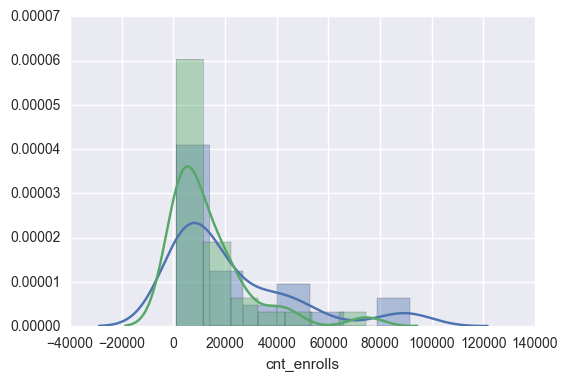

In [837]:
sns.distplot(enrollments_aggregate_30d_big3[enrollments_aggregate_30d_big3.course_self_paced=='Yes'].cnt_enrolls)
sns.distplot(enrollments_aggregate_30d_big3[enrollments_aggregate_30d_big3.course_self_paced=='No'].cnt_enrolls)


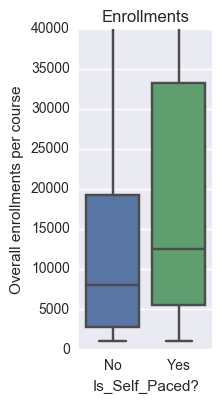

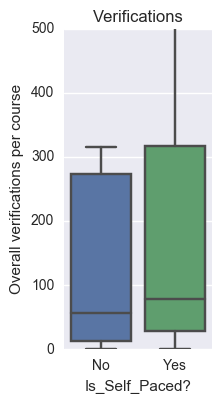

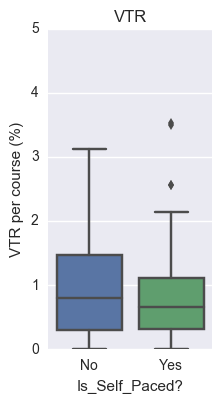

In [107]:
ax = sns.factorplot(data = enrollments_aggregate_30d_big3, x = 'course_self_paced', y = 'cnt_enrolls', kind = 'box', size = 4, aspect = .6)
ax.set(ylim=(0,40000), xlabel='Is_Self_Paced?', ylabel='Overall enrollments per course',
       title = 'Enrollments')

ax = sns.factorplot(data = enrollments_aggregate_30d_big3, x = 'course_self_paced', y = 'cnt_verifs', kind = 'box', size = 4, aspect = .6)
ax.set(ylim=(0,500), xlabel='Is_Self_Paced?', ylabel='Overall verifications per course',
       title = 'Verifications')
ax = sns.factorplot(data = enrollments_aggregate_30d_big3, x = 'course_self_paced', y = 'vtr', kind = 'box', size = 4, aspect = .6)
ax.set(ylim=(0,5), xlabel='Is_Self_Paced?', ylabel='VTR per course (%)',
       title = 'VTR')

In [ ]:
enrollments_aggregate_term = enrollments_and_completions_df.groupby(['course_subject','course_self_paced', 'course_id', 'course_term']).sum().reset_index()
enrollments_aggregate_term['vtr'] = enrollments_aggregate_term.cnt_verifs*100.0/enrollments_aggregate_term.cnt_enrolls
enrollments_aggregate_term = enrollments_aggregate_term[enrollments_aggregate_term.cnt_enrolls > 1000]

In [ ]:
ax = sns.factorplot(data = enrollments_aggregate_term, x = 'course_term', y = 'cnt_enrolls', 
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, ci = False)
ax.set(ylim=(0,30000), title = 'Avg Enrollment, Self Paced vs Instructor Led, Across Course Term')

ax = sns.factorplot(data = enrollments_aggregate_term, x = 'course_term', y = 'cnt_verifs',
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, ci = False)
ax.set(ylim=(0,400), title = 'Avg Verifications, Self Paced vs Instructor Led, Across Course Term')

ax = sns.factorplot(data = enrollments_aggregate_term, x = 'course_term', y = 'vtr',
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, ci = False)
ax.set(ylim=(0,2), title = 'Avg Vtr, Self Paced vs Instructor Led, Across Course Term')

In [ ]:
ax = sns.factorplot(data = enrollments_aggregate_term, x = 'course_term', y = 'cnt_enrolls', 
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, capsize = 0.02)
ax.set(ylim=(0,60000), title = 'Enrollments, Self Paced vs Instructor Led, Across Course Term')

ax = sns.factorplot(data = enrollments_aggregate_term, x = 'course_term', y = 'cnt_verifs',
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, capsize = 0.02)
ax.set(ylim=(0,800), title = 'Verifications, Self Paced vs Instructor Led, Across Course Term')

ax = sns.factorplot(data = enrollments_aggregate_term, x = 'course_term', y = 'vtr',
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, capsize = 0.02)
ax.set(ylim=(0,4), title = 'Vtr, Self Paced vs Instructor Led, Across Course Term')

In [ ]:
enrollments_aggregate_term_big3 = enrollments_aggregate_term[enrollments_aggregate_term.course_subject.str.contains('|'.join(big3_subjects))]

In [ ]:
ax = sns.factorplot(data = enrollments_aggregate_big3, x = 'course_self_paced', y = 'cnt_enrolls', kind = 'box', size = 8)
ax.set(ylim=(0,60000))

ax = sns.factorplot(data = enrollments_aggregate_big3, x = 'course_self_paced', y = 'cnt_verifs', kind = 'box', size = 8)
ax.set(ylim=(0,500))

ax = sns.factorplot(data = enrollments_aggregate_big3, x = 'course_self_paced', y = 'vtr', kind = 'box', size = 8)
ax.set(ylim=(0,5))

In [ ]:
ax = sns.factorplot(data = enrollments_aggregate_term_big3, x = 'course_term', y = 'cnt_enrolls', 
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, ci = False)
ax.set(ylim=(0,40000), title = 'Avg Enrollment, Self Paced vs Instructor Led, Across Course Term')

ax = sns.factorplot(data = enrollments_aggregate_term_big3, x = 'course_term', y = 'cnt_verifs',
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, ci = False)
ax.set(ylim=(0,1000), title = 'Avg Verifications, Self Paced vs Instructor Led, Across Course Term')

ax = sns.factorplot(data = enrollments_aggregate_term_big3, x = 'course_term', y = 'vtr',
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, ci = False)
ax.set(ylim=(0,4), title = 'Avg Vtr, Self Paced vs Instructor Led, Across Course Term')

In [ ]:
ax = sns.factorplot(data = enrollments_aggregate_term_big3, x = 'course_term', y = 'cnt_enrolls', 
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, capsize = 0.02)
ax.set(ylim=(0,60000), title = 'Enrollments, Self Paced vs Instructor Led, Across Course Term')

ax = sns.factorplot(data = enrollments_aggregate_term_big3, x = 'course_term', y = 'cnt_verifs',
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, capsize = 0.02)
ax.set(ylim=(0,800), title = 'Verifications, Self Paced vs Instructor Led, Across Course Term')

ax = sns.factorplot(data = enrollments_aggregate_term_big3, x = 'course_term', y = 'vtr',
                    kind = 'point', hue='course_self_paced', size = 8, order = plot_order, capsize = 0.02)
ax.set(ylim=(0,4), title = 'Vtr, Self Paced vs Instructor Led, Across Course Term')

In [ ]:

enrollments_14days_subject_filtered = enrollments_14days[enrollments_14days.course_subject.str.contains('|'.join(big3_subjects))]

In [299]:
enrollments_and_completions_df_30d_filtered.head()

,cnt_enrolls,cnt_verifs,course_id,course_self_paced,course_subject,course_term,pct_no_certificates,user_enroll_from_course_start_days_x,user_enroll_from_course_start_days_min_zero,user_verify_from_course_start_days,user_verify_from_course_start_days_min_zero,user_enroll_from_course_start_days_y
1474,70,0,course-v1:HKUSTx+COMP102.2x+1T2016,Yes,Computer Science,1T2016,99.7231775857730056203,78,78,NaN,NaN,-27.01
1475,26,0,course-v1:HKUSTx+COMP102.2x+1T2016,Yes,Computer Science,1T2016,99.7231775857730056203,115,115,NaN,NaN,-27.01
1476,1,1,course-v1:HKUSTx+COMP102.2x+1T2016,Yes,Computer Science,1T2016,99.7231775857730056203,-23,0,86.0,86.0,-27.01
1477,100,0,course-v1:HKUSTx+COMP102.2x+1T2016,Yes,Computer Science,1T2016,99.7231775857730056203,41,41,NaN,NaN,-27.01
1478,155,0,course-v1:HKUSTx+COMP102.2x+1T2016,Yes,Computer Science,1T2016,99.7231775857730056203,-18,0,NaN,NaN,-27.01


In [397]:
date_eval_list = np.arange(1,90)

for i in date_eval_list:
    
    #filter our df to only aggregate from self_paced courses depending on how far out from the course_enroll date it is
    #trying to understand - from an enrollment perspective, at what point can we no longer discern pacing?
    
    subset_df = enrollments_and_completions_df_30d_filtered[((enrollments_and_completions_df_30d_filtered.course_self_paced == 'Yes') & (enrollments_and_completions_df_30d_filtered.user_enroll_from_course_start_days_x <= i))|(enrollments_and_completions_df_30d_filtered.course_self_paced == 'No')]
    enroll_col_name = 'cnt_enrolls_%d_days' % i
    enrollments_aggregate_30d[enroll_col_name] = subset_df.groupby(['course_subject','course_self_paced', 'course_id']).sum().reset_index()['cnt_enrolls']
    

In [477]:
t_test_results_df = pd.DataFrame(columns=['Days', 'p-value'])
enrollments_aggregate_30d = enrollments_aggregate_30d[enrollments_aggregate_30d.cnt_enrolls > 100]
self = enrollments_aggregate_30d[enrollments_aggregate_30d.course_self_paced=='Yes'].fillna(value=1)
instructor = enrollments_aggregate_30d[enrollments_aggregate_30d.course_self_paced=='No'].fillna(value=1)

for i in date_eval_list:
        col = 'cnt_enrolls_%d_days' % i
        df_to_append = pd.DataFrame({
                             'Days': [i],
                             'p-value':[ttest_ind(np.log(self[col]), np.log(instructor[col]))[1]]
                             })
        t_test_results_df = t_test_results_df.append(df_to_append)

In [478]:
#ax =sns.factorplot(data = enrollments_aggregate_30d,x='course_self_paced', y = np.log(enrollments_aggregate_30d.cnt_enrolls_44_days).dropna(), kind='box')
#ax.set(ylim=(0,40000))

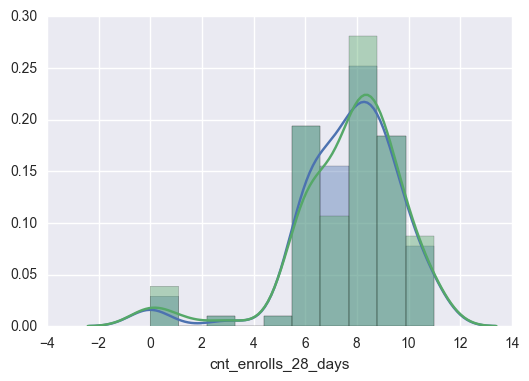

In [488]:
sns.distplot(np.log(enrollments_aggregate_30d[enrollments_aggregate_30d['course_self_paced']=='Yes'].cnt_enrolls_27_days).dropna())
sns.distplot(np.log(enrollments_aggregate_30d[enrollments_aggregate_30d['course_self_paced']=='Yes'].cnt_enrolls_28_days).dropna())

In [483]:
t_test_results_df.head()

,Days,p-value
0,1.0,0.307855
0,2.0,0.148386
0,3.0,0.187639
0,4.0,0.220803
0,5.0,0.253727


In [481]:
t_test_results_df.set_index('Days')['p-value'].argmax()

56.0

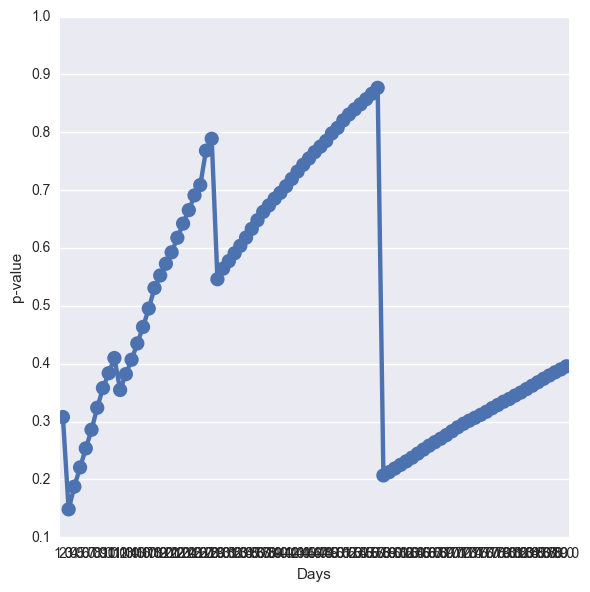

In [482]:
sns.factorplot(data=t_test_results_df,x='Days',y='p-value', size = 6)

In [513]:
enrollments_aggregate_filtered = enrollments_aggregate[enrollments_aggregate.course_subject.str.contains('|'.join(big3_subjects))]

In [ ]:
enrollments_aggregate = enrollments_aggregate[enrollments_aggregate.cnt_enrolls > 100]
self = enrollments_aggregate[enrollments_aggregate.course_self_paced=='Yes'].fillna(value=0)
instructor = enrollments_aggregate[enrollments_aggregate.course_self_paced=='No'].fillna(value=0)

In [ ]:
t_test_results_df = pd.DataFrame(columns=['Subject', 'Days', 'p-value'])
for j in subject_list:
    for i in date_eval_list:
        col = 'cnt_enrolls_%d_days' % i
        self_subject = self[self.course_subject == j]
        instructor_subject = instructor[instructor.course_subject == j]
        #sns.factorplot(data = enrollments_aggregate, x = 'course_self_paced', y = col, kind = 'bar',size = 6)
        df_to_append = pd.DataFrame({'Subject': [j],
                             'Days': [i],
                             'p-value':[ttest_ind(self_subject[col], instructor_subject[col])[1]]
                             })
        t_test_results_df = t_test_results_df.append(df_to_append)

In [ ]:
for j in subject_list:
    ax = sns.factorplot(data = t_test_results_df[t_test_results_df.Subject==j], x='Days', y='p-value')
    ax.set(title=j)

* * *
# Enrollment Curves
* * *

In [21]:
enrollments_and_completions_df.head()

,cnt_enrolls,cnt_verifs,course_id,course_self_paced,course_subject,course_term,pct_no_certificates,user_enroll_from_course_start_days,user_enroll_from_course_start_days_min_zero,user_verify_from_course_start_days,user_verify_from_course_start_days_min_zero
0,1,1,course-v1:GeorgetownX+MEDX202-01+2015_3T,No,Biology & Life Sciences,None,0E-19,-6,0,43.0,43.0
1,8,0,course-v1:UC3Mx+PCA.1x+2T2015,No,Art & Culture,2T2015,3.4642857142857142857,84,84,NaN,NaN
2,1165,0,HarvardX/CS50x3/2015,Yes,None,None,0.0001491437656414524,173,173,NaN,NaN
3,181,0,course-v1:AdelaideX+Lang101x+2T2015,No,Communication,2T2015,0E-19,-14,0,NaN,NaN
4,1,1,course-v1:UTAustinX+UT.4.10x+3T2015,No,Data Analysis & Statistics,3T2015,0E-19,14,14,14.0,14.0


In [22]:
enrollments_and_completions_df = enrollments_and_completions_df.set_index(['course_id','course_self_paced','course_subject','user_enroll_from_course_start_days','pct_no_certificates']) 
enrollments = enrollments_and_completions_df.groupby(level=[0,1,2,3,4]).sum().groupby(level=[0]).cumsum().reset_index()

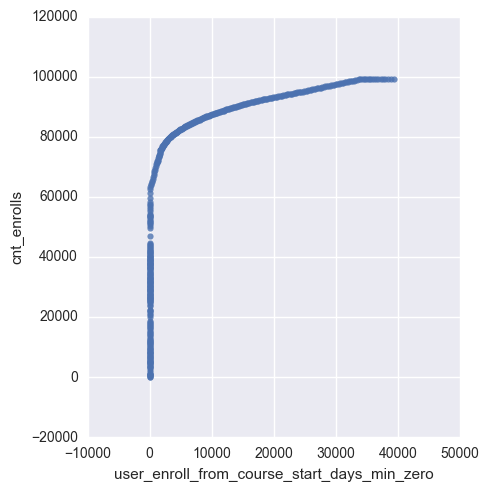

In [24]:
sns.lmplot(data = enrollments[enrollments.course_id=='BerkeleyX/CS100.1x/1T2015'],
           x='user_enroll_from_course_start_days_min_zero', y = 'cnt_enrolls', fit_reg = False)

In [25]:
microsoft_courses_array = [
'DAT202.2x',
'DAT203x',
'DAT204x',
'DAT206x',
'DAT208x',
'DEV209.1x',
'DEV209.2x',
'DEV209.3x'
]

In [37]:
pace_order = ['No', 'Yes']

In [32]:
enrollments['course_plus_pacing'] = enrollments.course_id.str.cat(enrollments.course_self_paced, sep = '+')

In [26]:
enrollments_microsoft = enrollments[enrollments.course_id.str.contains('|'.join(microsoft_courses_array))]
enrollments_microsoft = enrollments_microsoft[enrollments_microsoft.course_id.str.contains('DAT202.2x\+3T2016')]

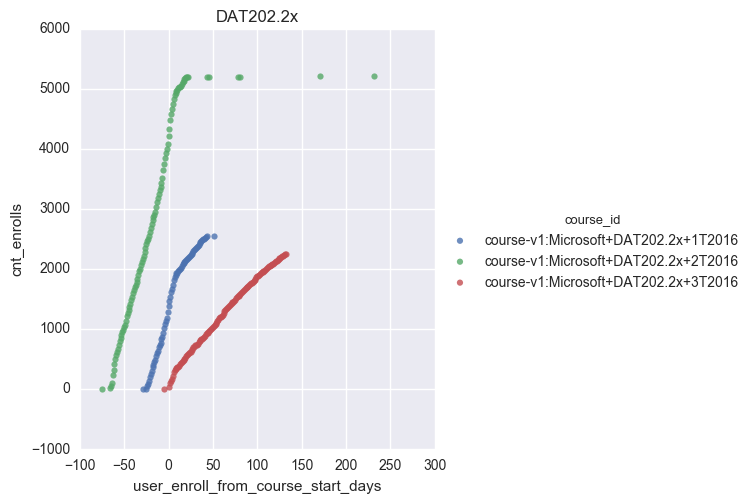

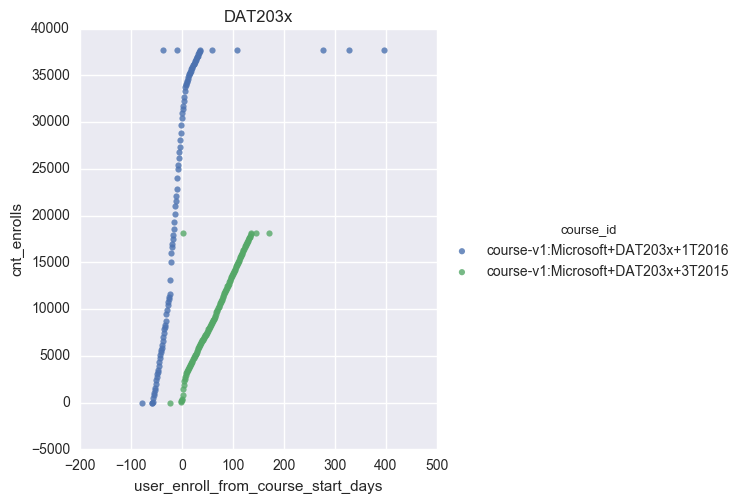

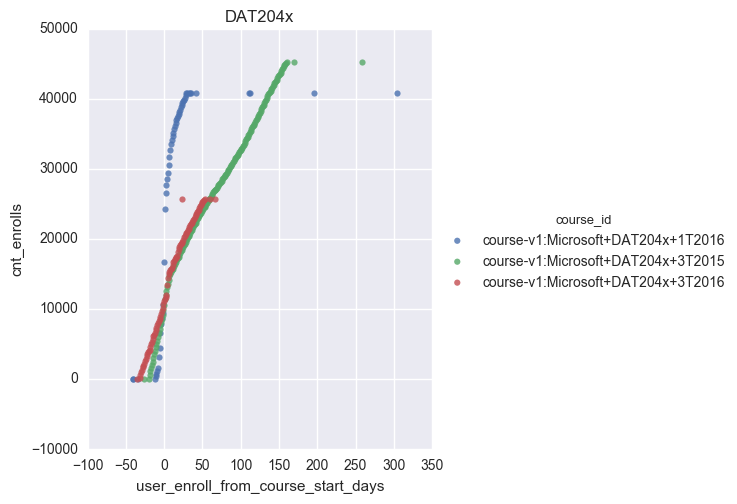

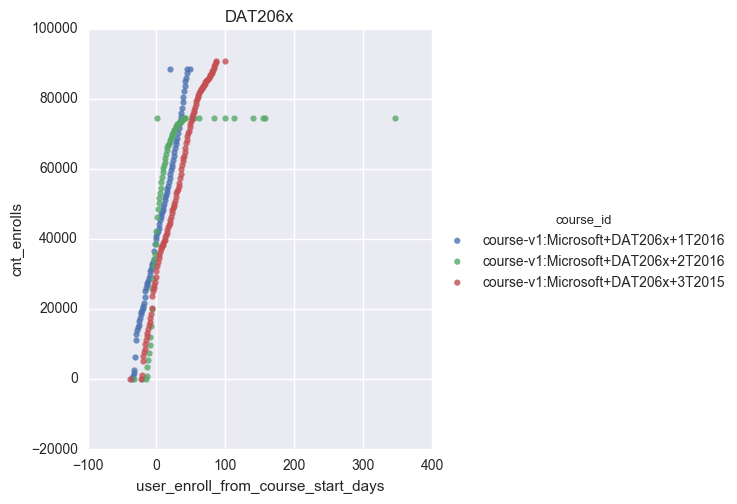

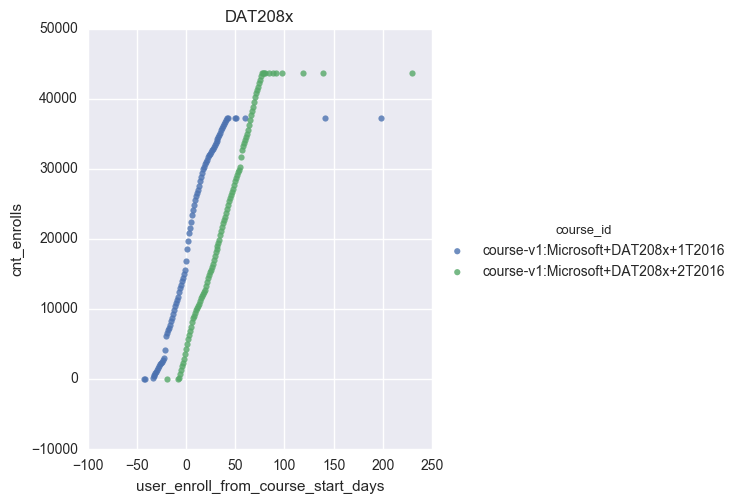

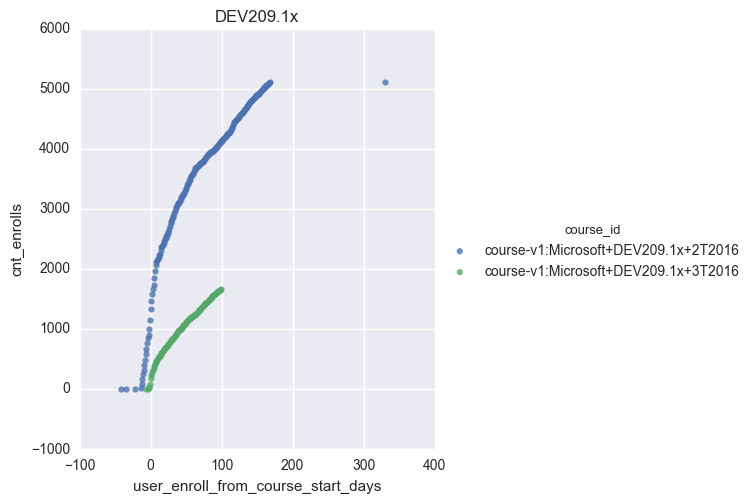

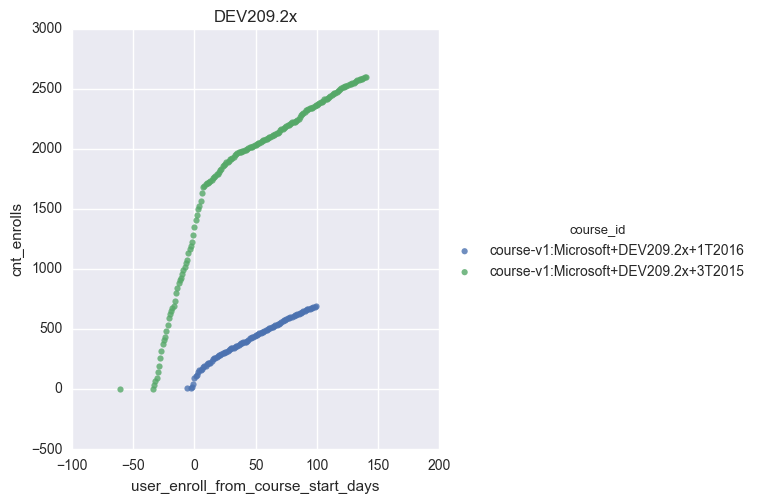

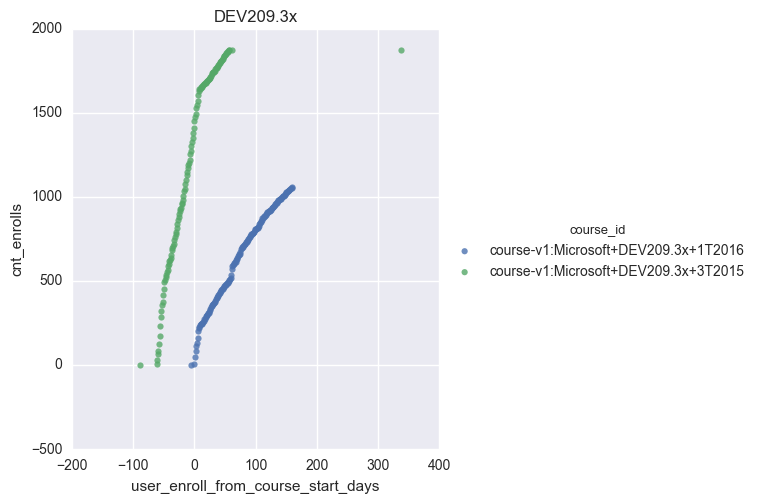

In [126]:
for i in microsoft_courses_array:
    ax = sns.lmplot(data = enrollments[enrollments.course_id.str.contains(i)],
           x='user_enroll_from_course_start_days', y = 'cnt_enrolls', fit_reg = False, 
           hue='course_id', order=pace_order, legend=True)
    ax.set(title=i)        

In [ ]:
enrollments[enrollments.course_id.str.contains('DAT204')]

In [157]:
enrollments['pct_enroll_change']=enrollments.groupby('course_id').pct_change().cnt_enrolls*100.0

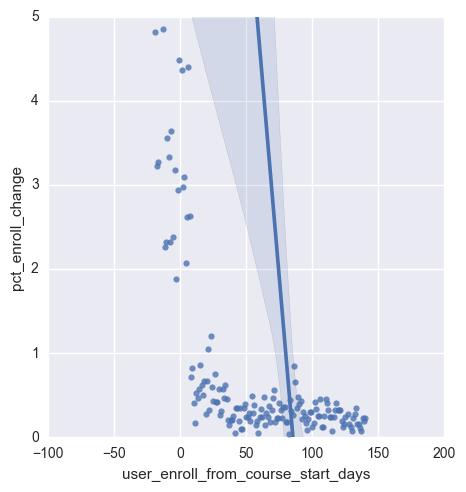

In [159]:
ax = sns.lmplot(data=enrollments[enrollments.course_id == 'course-v1:Microsoft+DEV209.2x+3T2015'],x='user_enroll_from_course_start_days', y = 'pct_enroll_change')
ax.set(ylim=(0,5))

In [131]:
max_date = enrollments[enrollments.course_id == 'course-v1:Microsoft+DEV209.2x+3T2015'].user_enroll_from_course_start_days.max()

In [186]:
def pct_enrollment_drop(day, median_growth):
    pct_decrease_monthly_enrollments = 10
    projected_growth_pct = median_growth * (1 - (1.0/(3000/pct_decrease_monthly_enrollments)) * i)
    return projected_growth_pct

In [273]:
self_paced_df = enrollments[enrollments.course_self_paced == 'Yes']

In [278]:
course_list = self_paced_df.course_id.unique()


In [283]:
course_list

array(['ANUx/ANU-ASTRO2x/2T2014', 'ANUx/ANU-ASTRO4x/1T2015',
       'HarvardX/GSE3x/1T2015', 'HarvardX/MCB80.1x/2013_SOND',
       'HarvardX/MCB80.2x/3T2014', 'HarvardX/PH525.1x/1T2015',
       'HarvardX/PH525.2x/1T2015', 'HarvardX/PH525.3x/1T2015',
       'HarvardX/PH525.4x/1T2015', 'HarvardX/PH525.5x/1T2015',
       'HarvardX/PH525.6x/1T2015', 'HarvardX/PH525.7x/1T2015',
       'HarvardX/PH525.8x/1T2015', 'HarveyMuddX/CS001x/1T2015',
       'HarveyMuddX/CS005x/2T2015', 'IITBombayX/ME209.1x/2T2015',
       'SchoolYourself/AlgebraX/1T2015', 'SchoolYourself/GeometryX/1T2015',
       'TBRx/STATx/1T2015', 'WestonHS/MechC101x/2T2015',
       'WestonHS/PFLC1x/3T2015', 'course-v1:ANUx+ANU-ASTRO1x+3T2015',
       'course-v1:ANUx+ANU-ASTRO2x+4T2015',
       'course-v1:ANUx+ANU-ActuarialX+4T2015',
       'course-v1:ANUx+ANU-INDIA1x+4T2015',
       'course-v1:AdelaideX+Code101x+3T2015',
       'course-v1:AdelaideX+HumBio101x+2T2015',
       'course-v1:BerkeleyX+ColWri3.1x-2+3T2015',
       'cour

In [279]:
self_paced_df.head()

,course_id,course_self_paced,course_subject,user_enroll_from_course_start_days,pct_no_certificates,cnt_enrolls,cnt_verifs,user_enroll_from_course_start_days_min_zero,user_verify_from_course_start_days,user_verify_from_course_start_days_min_zero,course_plus_pacing,pct_enroll_change
0,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-176,8.5393085393085393085,28,0,0,NaN,NaN,ANUx/ANU-ASTRO2x/2T2014+Yes,NaN
1,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-175,8.5393085393085393085,296,4,0,-175.0,0.0,ANUx/ANU-ASTRO2x/2T2014+Yes,957.142857
2,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-174,8.5393085393085393085,455,7,0,-305.0,44.0,ANUx/ANU-ASTRO2x/2T2014+Yes,53.716216
3,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-173,8.5393085393085393085,588,10,0,-469.0,53.0,ANUx/ANU-ASTRO2x/2T2014+Yes,29.230769
4,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-172,8.5393085393085393085,688,12,0,-641.0,53.0,ANUx/ANU-ASTRO2x/2T2014+Yes,17.006803


In [290]:
growth_df = pd.DataFrame(columns=['course','growth_pct', 'last_enroll_date'])

for i in course_list:
    growth_dict = {}
    median_growth = self_paced_df[self_paced_df.course_id==i].groupby('course_id').pct_change().cnt_enrolls[-30:].median()
    last_enroll_date = self_paced_df[self_paced_df.course_id==i].groupby('course_id').quantile(0.95).user_enroll_from_course_start_days.values[0]
    growth_dict = {
        
        'course': [i],
        'growth_pct': [median_growth],
        'last_enroll_date': [last_enroll_date]  
    }
    growth_df = growth_df.append(pd.DataFrame(growth_dict))
    

In [295]:
growth_df[growth_df.last_enroll_date<120]#.course.unique()

,course,growth_pct,last_enroll_date
0,WestonHS/MechC101x/2T2015,0.003435,40.05
0,course-v1:ANUx+ANU-ActuarialX+4T2015,0.008004,56.30
0,course-v1:BerkeleyX+ColWri3.1x-2+3T2015,0.000815,59.60
0,course-v1:CatalystX+IL4x+2015_T3,0.007585,66.05
0,course-v1:CooperUnion+Chem.1x+3T2015,0.009725,117.65
0,course-v1:CooperUnion+Chem.2x+3T2015,0.009531,117.70
0,course-v1:DelftX+CalcSP01x+3T2015,0.005353,114.60
0,course-v1:HKUSTx+COMP102.2x+1T2016,0.003709,111.60
0,course-v1:HarvardX+PH525.4x+3T2015,0.002509,97.10
0,course-v1:HarvardX+PH525.5x+3T2015,0.003123,67.05


In [191]:
enrollments = pd.merge(enrollments, enrollments.groupby('course_id').max().user_enroll_from_course_start_days.reset_index(), how='inner', on='course_id')
enrollments = pd.merge(enrollments, enrollments.groupby('course_id').max().user_enroll_from_course_start_days.reset_index(), how='inner', on='course_id')


,course_id,course_self_paced,course_subject,user_enroll_from_course_start_days_x,pct_no_certificates,cnt_enrolls,cnt_verifs,user_enroll_from_course_start_days_min_zero,user_verify_from_course_start_days,user_verify_from_course_start_days_min_zero,course_plus_pacing,pct_enroll_change,user_enroll_from_course_start_days_y
0,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-176,8.5393085393085393085,28,0,0,NaN,NaN,ANUx/ANU-ASTRO2x/2T2014+Yes,NaN,405
1,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-175,8.5393085393085393085,296,4,0,-175.0,0.0,ANUx/ANU-ASTRO2x/2T2014+Yes,957.142857,405
2,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-174,8.5393085393085393085,455,7,0,-305.0,44.0,ANUx/ANU-ASTRO2x/2T2014+Yes,53.716216,405
3,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-173,8.5393085393085393085,588,10,0,-469.0,53.0,ANUx/ANU-ASTRO2x/2T2014+Yes,29.230769,405
4,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-172,8.5393085393085393085,688,12,0,-641.0,53.0,ANUx/ANU-ASTRO2x/2T2014+Yes,17.006803,405
5,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-171,8.5393085393085393085,746,14,0,-563.0,302.0,ANUx/ANU-ASTRO2x/2T2014+Yes,8.430233,405
6,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-170,8.5393085393085393085,808,15,0,-733.0,302.0,ANUx/ANU-ASTRO2x/2T2014+Yes,8.310992,405
7,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-169,8.5393085393085393085,865,16,0,-705.0,330.0,ANUx/ANU-ASTRO2x/2T2014+Yes,7.054455,405
8,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-168,8.5393085393085393085,935,18,0,-873.0,330.0,ANUx/ANU-ASTRO2x/2T2014+Yes,8.092486,405
9,ANUx/ANU-ASTRO2x/2T2014,Yes,Physics,-167,8.5393085393085393085,1002,21,0,-1005.0,385.0,ANUx/ANU-ASTRO2x/2T2014+Yes,7.165775,405


In [184]:
for row_index, row in enrollments[enrollments.course_id == 'course-v1:Microsoft+DEV209.2x+3T2015'].iterrows():
    if(row['user_enroll_from_course_start_days'] <= row['max_date']):
        enrollments['proj_enrollment'] = row['cnt_enrolls']
    else:
        enrollments['proj_enrollment'] = (pct_enrollment_drop(row['user_enroll_from_course_start_days'] - row['max_date'], row['median_growth']) * enrollments.ix[row_index - 1]['cnt_enrolls']) + enrollments.ix[row_index - 1]['cnt_enrolls']

3
6
32
68
96
142
197
259
319
373
410
434
486
535
592
622
652
673
695
732
802
845
886
906
927
960
992
1015
1052
1077
1132
1168
1190
1225
1280
1351
1410
1452
1497
1528
1568
1637
1680
1692
1706
1713
1716
1725
1733
1743
1758
1769
1778
1790
1795
1807
1826
1832
1854
1865
1873
1887
1895
1903
1914
1919
1925
1936
1945
1957
1966
1970
1973
1977
1981
1986
1987
1994
2001
2005
2012
2014
2016
2023
2031
2036
2041
2047
2051
2061
2067
2075
2078
2082
2083
2088
2095
2100
2110
2113
2119
2124
2132
2136
2143
2153
2165
2169
2174
2179
2188
2195
2200
2208
2216
2220
2224
2225
2235
2242
2248
2267
2282
2290
2301
2310
2320
2325
2332
2338
2342
2344
2349
2356
2363
2366
2370
2380
2388
2394
2400
2411
2414
2417
2423
2434
2444
2452
2458
2464
2466
2472
2480
2490
2498
2506
2514
2519
2522
2526
2532
2539
2543
2546
2548
2554
2561
2570
2574
2578
2581
2583
2589
2594
2600


# Archive
### Stuff I don't want to lose

In [ ]:
enrollments_microsoft['diff']=enrollments_microsoft['cnt'].diff(periods=1)
enrollments_microsoft['pct_change']=enrollments_microsoft['cnt'].pct_change(periods=1)
enrollments_microsoft['pct_change2']=(np.gradient(enrollments_microsoft.cnt, edge_order=2))
enrollments_microsoft.sort_values('pct_change2',ascending=False)
spl = UnivariateSpline(np.arange(len(enrollments_microsoft)), np.gradient(enrollments_microsoft.cnt), k=5)
spl.set_smoothing_factor(1000)
enrollments_microsoft['spline']=spl(np.arange(len(enrollments_microsoft)))
spl.set_smoothing_factor(1000)
enrollments_microsoft['spline2']=spl(np.arange(len(enrollments_microsoft)))
enrollments_microsoft['gradient_spline2']=abs(np.gradient(np.gradient(enrollments_microsoft.spline2)))
enrollments_microsoft['second_deriv']=abs(np.gradient(np.gradient(enrollments_microsoft.cnt)))

In [ ]:
sns.lmplot(data = enrollments_microsoft,
           x='user_enroll_from_course_start_days', y = 'cnt', fit_reg = False)

sns.lmplot(data = enrollments_microsoft,
           x='user_enroll_from_course_start_days', y = 'diff', fit_reg = False)

sns.lmplot(data = enrollments_microsoft,
           x='user_enroll_from_course_start_days', y = 'pct_change', fit_reg = False)

In [ ]:
sns.lmplot(data = enrollments_microsoft,
           x='user_enroll_from_course_start_days', y = 'cnt', fit_reg = False, 
           #hue='course_id')
           hue='course_self_paced')
sns.lmplot(data = enrollments_microsoft,
           x='user_enroll_from_course_start_days', y = 'spline', fit_reg = False, 
           #hue='course_id')
           hue='course_self_paced')
sns.lmplot(data = enrollments_microsoft,
           x='user_enroll_from_course_start_days', y = 'spline2', fit_reg = False, 
           #hue='course_id')
           hue='course_self_paced')
sns.lmplot(data = enrollments_microsoft,
           x='user_enroll_from_course_start_days', y = 'gradient_spline2', fit_reg = False, 
           #hue='course_id')
           hue='course_self_paced')
sns.lmplot(data = enrollments_microsoft,
           x='user_enroll_from_course_start_days', y = 'second_deriv', fit_reg = False, 
           #hue='course_id')
           hue='course_self_paced')